# Autoencoders

In [6]:
pip install fastprogress

Note: you may need to restart the kernel to use updated packages.


In [98]:
# import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import pickle,gzip,math,os,time,shutil,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
# from functools import partial
from cytoolz import curry, identity, valmap

# from torch import tensor,nn,optim
# from torch.utils.data import DataLoader,default_collate
# import torch.nn.functional as F
# import torchvision.transforms.functional as TF
from datasets import load_dataset,load_dataset_builder

from fastprogress import progress_bar,master_bar

import sys
sys.path.append('..')
from miniai.datasets import *
from miniai.training import *
from miniai.conv import *

import tensorflow as tf

In [99]:
from fastcore.test import test_close

# torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
# torch.manual_seed(1)
tf.random.set_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

## Data

In [100]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name, ignore_verifications=True)

In [18]:
# @inplace
# def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

In [21]:
bs = 256
# tds = dsd.with_transform(transformi)
tds = dsd.with_transform(identity)

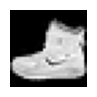

In [22]:
ds = tds['train']
img = ds[0]['image']
show_image(img, figsize=(1,1));

In [23]:
# cf = collate_dict(ds)

In [24]:
# def collate_(b): return to_device(cf(b))
# def data_loaders(dsd, bs, **kwargs): return {k:DataLoader(v, bs, **kwargs) for k,v in dsd.items()}

In [25]:
# dls = data_loaders(tds, bs, collate_fn=collate_)

In [106]:
tds['train'].num_rows

60000

In [120]:
tds['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In [107]:
class GenCallable:
    def __init__(self, ds):
        self.ds = ds
        self.make_tensorspec()
        
    def __call__(self):
        for i in self.ds: yield i

    def make_tensorspec(self):
        one = self.ds[0]
        keys = one.keys()
        as_tns = valmap(tf.constant, one)
        shape = valmap(lambda tns: tf.rank(tns), as_tns)
        d_type = valmap(lambda tns: tns.dtype, as_tns)
        self.tensorspec = {k: tf.TensorSpec(shape=[None for _ in range(shape[k])], dtype=d_type[k]) for k in keys}

    def __len__(self):
        return ds.num_rows

In [108]:
traingen = GenCallable(tds['train'])
valgen = GenCallable(tds['test'])

In [110]:
dls = {
    'train':(
        tf.data.Dataset.from_generator(traingen, output_signature=traingen.tensorspec)
        .cache()
        .repeat()
        .shuffle(1024)
        .batch(bs)
        .prefetch(tf.data.AUTOTUNE)
    ),
    'test':(
        tf.data.Dataset.from_generator(valgen, output_signature=valgen.tensorspec)
        .cache()
        .repeat()
        .batch(bs)
        .prefetch(tf.data.AUTOTUNE)
    )
}

In [111]:
dt = dls['train']
dv = dls['test']

one = next(iter(dt))
# xb,yb = next(iter(dt))
xb, yb = one['image'], one['label']

2023-11-14 15:40:04.166646: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [112]:
labels = ds.features[y].names

In [113]:
labels

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [114]:
lbl_getter = itemgetter(*yb[:16])
titles = lbl_getter(labels)

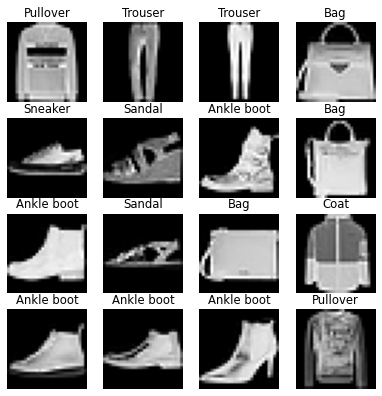

In [115]:
mpl.rcParams['figure.dpi'] = 70
show_images(xb[:16], imsize=1.7, titles=titles)

## Warmup - classify

In [116]:
# from torch import optim
from tensorflow.keras import optimizers

bs = 256
lr = 0.4

In [138]:
# cnn = nn.Sequential(
#     conv(1 ,4),            #14x14
#     conv(4 ,8),            #7x7
#     conv(8 ,16),           #4x4
#     conv(16,16),           #2x2
#     conv(16,10, act=False),
#     nn.Flatten()).to(def_device)

cnn = tf.keras.Sequential([
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,16),           #2x2
    conv(16,10, act=False),
    tf.keras.layers.Flatten()
])

In [143]:
class CNN(tf.keras.Model):
    def __init__(self):
        super().__init__()

        self.sequential = cnn

    def call(self, inputs):
        x,label = tf.cast(inputs['image'][:,:,:,None], dtype=tf.float32), inputs['label']
        return self.sequential(x), label

    def train_step(self, inputs):
        with tf.GradientTape() as tape:
            preds, label = self(inputs)
            loss = self.loss(label, preds)

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        if not isinstance(loss, dict):
            loss = {'loss':loss}
            
        return loss

In [ ]:
# opt = optim.SGD(cnn.parameters(), lr=lr)
# loss,acc = fit(5, cnn, F.cross_entropy, opt, dt, dv)

opt = optimizers.SGD(learning_rate=lr)
cnn_m = CNN()
cnn_m.compile(
    optimizer=opt,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
history = cnn_m.fit(
    dt,
    validation_data=dv, 
    steps_per_epoch=len(traingen)//bs, 
    validation_steps=len(valgen)//bs,
    epochs=5,
)

Epoch 1/5


## Autoencoder

In [2]:
# def deconv(ni, nf, ks=3, act=True):
#     layers = [nn.UpsamplingNearest2d(scale_factor=2),
#               nn.Conv2d(ni, nf, stride=1, kernel_size=ks, padding=ks//2)]
#     if act: layers.append(nn.ReLU())
#     return nn.Sequential(*layers)

def deconv(ni, nf, ks=3, act=True):
    layers = [
        tf.keras.layers.UpSampling2D(size=2),
        tf.keras.layers.Conv2D(nf, strides=1, kernel_size=ks, padding='same', activation='relu' if act else None)
     ]
    return tf.kears.Sequential(layers)

# ????????????? Might be silly to do this

In [ ]:
# def eval(model, loss_func, valid_dl, epoch=0):
#     model.eval()
#     with torch.no_grad():
#         tot_loss,count = 0.,0
#         for xb,_ in valid_dl:
#             pred = model(xb)
#             n = len(xb)
#             count += n
#             tot_loss += loss_func(pred,xb).item()*n
#     print(epoch, f'{tot_loss/count:.3f}')

In [3]:
# def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
#     for epoch in range(epochs):
#         model.train()
#         for xb,_ in train_dl:
#             loss = loss_func(model(xb), xb)
#             loss.backward()
#             opt.step()
#             opt.zero_grad()
#         eval(model, loss_func, valid_dl, epoch)

In [ ]:
# ae = nn.Sequential(   #28x28
#     nn.ZeroPad2d(2),  #32x32
#     conv(1,2),        #16x16
#     conv(2,4),        #8x8
# #     conv(4,8),        #4x4
# #     deconv(8,4),      #8x8
#     deconv(4,2),      #16x16
#     deconv(2,1, act=False), #32x32
#     nn.ZeroPad2d(-2), #28x28
#     nn.Sigmoid()
# ).to(def_device)

ae = tf.keras.Sequential([
    tf.keras.layers.ZeroPad2D(2),
    conv(1,2),
    conv(2,4),
    # conv(4,8),
    # deconv(8,4),
    deconv(4,2),
    deconv(2,1, act=False)
    tf.keras.layers.ZeroPad2D(-2),
    # no sigmoid for better math
])

In [ ]:
# eval(ae, F.mse_loss, dv)

0 0.158


In [4]:
# opt = optim.SGD(ae.parameters(), lr=0.01)
# fit(5, ae, F.mse_loss, opt, dt, dv)

In [5]:
# opt = optim.SGD(ae.parameters(), lr=0.1)
# fit(5, ae, F.mse_loss, opt, dt, dv)

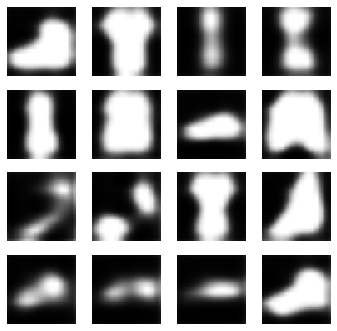

In [ ]:
p = ae(xb)
show_images(p[:16].data.cpu(), imsize=1.5)

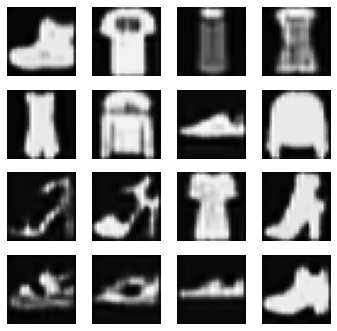

In [ ]:
p = ae(xb)
show_images(p[:16].data.cpu(), imsize=1.5)

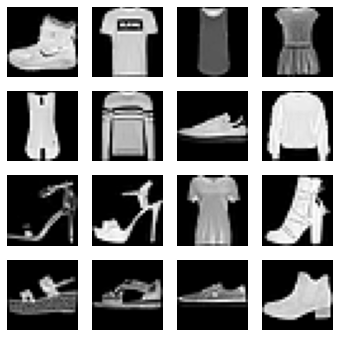

In [ ]:
show_images(xb[:16].data.cpu(), imsize=1.5)